In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import torch.utils.data as data
import torch
from torch import nn, optim
import torch.nn.functional as F
import tqdm
from tqdm import tnrange
import copy

C:\Users\franc\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('data.csv', delimiter=",")
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
df_eval = pd.read_csv('evaluation_data.csv', delimiter=",")
df_eval.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-20,1,0,1,0,0,4,1,1,0.26,0.2273,0.56,0.3881
1,2011-01-20,1,0,1,1,0,4,1,1,0.26,0.2727,0.56,0.0000
2,2011-01-20,1,0,1,2,0,4,1,1,0.26,0.2727,0.56,0.0000
3,2011-01-20,1,0,1,3,0,4,1,1,0.26,0.2576,0.56,0.1642
4,2011-01-20,1,0,1,4,0,4,1,1,0.26,0.2576,0.56,0.1642


In [4]:
df.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,8537.421183,2.506614,0.501929,6.521495,11.541613,0.028569,2.998622,0.680875,1.418427,0.493436,0.473102,0.618865,0.191036,36.021955,155.552177,191.574132
std,5026.363303,1.116174,0.500019,3.444373,6.915838,0.166599,2.007770,0.466159,0.633839,0.190039,0.169492,0.192450,0.121859,49.960477,151.039033,181.144454
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.015200,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4282.250000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.470000,0.104500,4.000000,36.000000,42.000000
50%,8666.500000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.620000,0.194000,17.000000,118.000000,145.000000
75%,13016.750000,4.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.640000,0.621200,0.770000,0.253700,49.000000,222.000000,284.000000
max,17093.000000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,0.909100,1.000000,0.850700,367.000000,886.000000,977.000000


In [5]:
df = df.drop(columns=['dteday', 'casual', 'registered', 'instant'])
df.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


In [6]:
df = df.astype(float)

In [7]:
train = df.iloc[:9500]
val = df.iloc[9500:]
# test = df.iloc[8500:]

In [8]:
df_eval = df_eval.drop(columns=['dteday'])
test = df_eval.astype(float)

In [9]:
test

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,1.0,0.0,1.0,0.0,0.0,4.0,1.0,1.0,0.26,0.2273,0.56,0.3881
1,1.0,0.0,1.0,1.0,0.0,4.0,1.0,1.0,0.26,0.2727,0.56,0.0000
2,1.0,0.0,1.0,2.0,0.0,4.0,1.0,1.0,0.26,0.2727,0.56,0.0000
3,1.0,0.0,1.0,3.0,0.0,4.0,1.0,1.0,0.26,0.2576,0.56,0.1642
4,1.0,0.0,1.0,4.0,0.0,4.0,1.0,1.0,0.26,0.2576,0.56,0.1642
...,...,...,...,...,...,...,...,...,...,...,...,...
6488,1.0,1.0,12.0,19.0,0.0,1.0,1.0,2.0,0.26,0.2576,0.60,0.1642
6489,1.0,1.0,12.0,20.0,0.0,1.0,1.0,2.0,0.26,0.2576,0.60,0.1642
6490,1.0,1.0,12.0,21.0,0.0,1.0,1.0,1.0,0.26,0.2576,0.60,0.1642
6491,1.0,1.0,12.0,22.0,0.0,1.0,1.0,1.0,0.26,0.2727,0.56,0.1343


In [10]:
X_train, y_train= train.drop('cnt', axis=1), train['cnt']
print(X_train.shape)

X_val, y_val = val.drop('cnt', axis=1), val['cnt']
print(X_val.shape)

X_test = test
print(X_test.shape)

(9500, 12)
(1386, 12)
(6493, 12)


In [11]:
f=20 # no. of batches

train_batch = np.array_split(X_train, f) 
label_batch = np.array_split(y_train, f) # 50 sections/batches

val_batch = np.array_split(X_val, f)
val_label_batch = np.array_split(y_val, f)

test_batch = np.array_split(X_test,f) 
# test_label_batch  = np.array_split(y_test, f)


for i in range(len(train_batch)):
    train_batch[i] = torch.from_numpy(train_batch[i].values).float()
for i in range(len(label_batch)):
    label_batch[i] = torch.from_numpy(label_batch[i].values).float().view(-1, 1)
    
for i in range(len(val_batch)):
    val_batch[i] = torch.from_numpy(val_batch[i].values).float()
for i in range(len(val_label_batch)):
    val_label_batch[i] = torch.from_numpy(val_label_batch[i].values).float().view(-1, 1)
    
    
for i in range(len(test_batch)):
    test_batch[i] = torch.from_numpy(test_batch[i].values).float()
# for i in range(len(test_label_batch)):
#     test_label_batch[i] = torch.from_numpy(test_label_batch[i].values).float().view(-1, 1)
    
print("Batch size:", len(train_batch[0]))


Batch size: 475


In [12]:
type(test_batch)

list

In [13]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(12, 24)
        self.fc2 = nn.Linear(24, 1)

        self.dropout = nn.Dropout(0.20)
       
    def forward(self, x):
        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))

        return x

model = Regressor()
train_losses, val_losses = [], []
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003) # 0.015 87
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.1, patience=15) 
total_epochs=0

In [14]:
best_model = copy.deepcopy(model)
best_val_loss = None

In [15]:
#print(model)
epochs = 2000
total_epochs+=epochs

model.train()

for e in range(epochs):
    
    train_loss = 0
    val_loss_1 = 0
    val_loss_sum = 0
    
    for i in range(len(train_batch)):
        
        output = model(train_batch[i])
        loss = criterion(output, label_batch[i])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
        with torch.no_grad():
            
            for j in range(len(val_batch)):
                
                val_output = model(val_batch[j])
                val_loss =  criterion(val_output, val_label_batch[j])
                val_loss_1+=val_loss.item()
        val_loss_sum=val_loss_1/len(val_batch)
        
    # saving best model
    val_loss_divided = val_loss_sum/len(val_batch)
    if best_val_loss is None or val_loss_divided < best_val_loss:
        print('Model replaced')
        best_val_loss = val_loss_divided
        best_model = copy.deepcopy(model)
    print("Epoch :", e, "train_loss :", train_loss/len(train_batch), "Val loss: ", val_loss_divided)    
    val_losses.append(val_loss_divided)    
    train_losses.append(train_loss/len(train_batch))   

Model replaced
Epoch : 0 train_loss : 64141.763671875 Val loss:  101232.34607421875
Model replaced
Epoch : 1 train_loss : 64006.714575195314 Val loss:  101003.54298828126
Model replaced
Epoch : 2 train_loss : 63860.325854492185 Val loss:  100769.03435546874
Model replaced
Epoch : 3 train_loss : 63712.585180664064 Val loss:  100513.323046875
Model replaced
Epoch : 4 train_loss : 63552.296557617185 Val loss:  100246.36041015625
Model replaced
Epoch : 5 train_loss : 63375.55471191406 Val loss:  99944.91019531249
Model replaced
Epoch : 6 train_loss : 63176.43420410156 Val loss:  99614.98993164062
Model replaced
Epoch : 7 train_loss : 62962.04194335938 Val loss:  99259.59645507814
Model replaced
Epoch : 8 train_loss : 62725.46638183594 Val loss:  98860.1469140625
Model replaced
Epoch : 9 train_loss : 62476.67338867187 Val loss:  98444.59077148438
Model replaced
Epoch : 10 train_loss : 62215.25327148438 Val loss:  97991.76954101563
Model replaced
Epoch : 11 train_loss : 61921.183374023436 Va

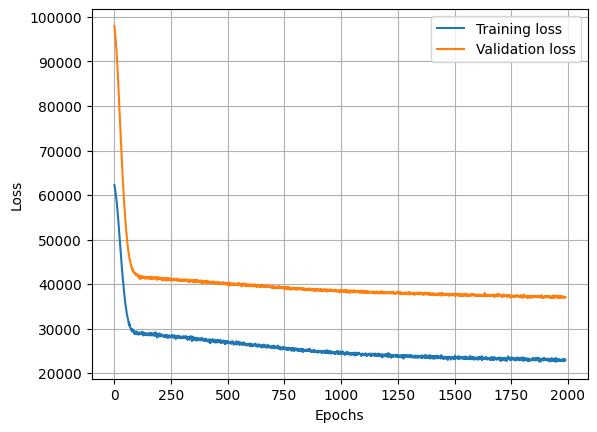

In [16]:
frm=10 # does not 
plt.plot(train_losses[frm:], label='Training loss')
plt.plot(val_losses[frm:], label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()

In [17]:
# model.eval()
# correct=0
# i=0
# res=[]
# with torch.no_grad():
#     for batch in test_batch :
#         for j in range(len(batch)):
#             x = model(batch[j])
#             #print(round(x.item()))
#             res.append(round(x.item()))

# true_labels= list(test["cnt"])

# for i in range(len(res)):
#     if res[i]==int(true_labels[i]):
#         correct+=1
        
# print("Accuracy:", 100*(correct/len(res)), "%")

In [18]:
len(test_batch)

20

In [19]:
test_outputs = []
for j in range(len(test_batch)):
    print()
    test_output = model(test_batch[j])
    print(len(test_output.unsqueeze(dim=1)))
    for value in test_output:
        test_outputs.append(value)
    print(len(test_outputs))


325
325

325
650

325
975

325
1300

325
1625

325
1950

325
2275

325
2600

325
2925

325
3250

325
3575

325
3900

325
4225

324
4549

324
4873

324
5197

324
5521

324
5845

324
6169

324
6493


In [20]:
len(test_outputs)

6493

In [21]:
test_outputs

[tensor([90.8901], grad_fn=<UnbindBackward0>),
 tensor([27.2021], grad_fn=<UnbindBackward0>),
 tensor([43.3647], grad_fn=<UnbindBackward0>),
 tensor([43.9300], grad_fn=<UnbindBackward0>),
 tensor([32.5785], grad_fn=<UnbindBackward0>),
 tensor([71.5987], grad_fn=<UnbindBackward0>),
 tensor([54.2160], grad_fn=<UnbindBackward0>),
 tensor([94.7721], grad_fn=<UnbindBackward0>),
 tensor([107.0843], grad_fn=<UnbindBackward0>),
 tensor([97.0038], grad_fn=<UnbindBackward0>),
 tensor([173.6839], grad_fn=<UnbindBackward0>),
 tensor([98.6544], grad_fn=<UnbindBackward0>),
 tensor([112.5834], grad_fn=<UnbindBackward0>),
 tensor([136.4189], grad_fn=<UnbindBackward0>),
 tensor([112.6580], grad_fn=<UnbindBackward0>),
 tensor([151.3485], grad_fn=<UnbindBackward0>),
 tensor([22.9464], grad_fn=<UnbindBackward0>),
 tensor([138.3977], grad_fn=<UnbindBackward0>),
 tensor([196.2789], grad_fn=<UnbindBackward0>),
 tensor([97.9635], grad_fn=<UnbindBackward0>),
 tensor([118.6938], grad_fn=<UnbindBackward0>),
 ten

In [22]:
list_output = []
for output in test_outputs:
    print('OUTPUT', output)
    list_output.append(output.item())

len(list_output)

OUTPUT tensor([90.8901], grad_fn=<UnbindBackward0>)
OUTPUT tensor([27.2021], grad_fn=<UnbindBackward0>)
OUTPUT tensor([43.3647], grad_fn=<UnbindBackward0>)
OUTPUT tensor([43.9300], grad_fn=<UnbindBackward0>)
OUTPUT tensor([32.5785], grad_fn=<UnbindBackward0>)
OUTPUT tensor([71.5987], grad_fn=<UnbindBackward0>)
OUTPUT tensor([54.2160], grad_fn=<UnbindBackward0>)
OUTPUT tensor([94.7721], grad_fn=<UnbindBackward0>)
OUTPUT tensor([107.0843], grad_fn=<UnbindBackward0>)
OUTPUT tensor([97.0038], grad_fn=<UnbindBackward0>)
OUTPUT tensor([173.6839], grad_fn=<UnbindBackward0>)
OUTPUT tensor([98.6544], grad_fn=<UnbindBackward0>)
OUTPUT tensor([112.5834], grad_fn=<UnbindBackward0>)
OUTPUT tensor([136.4189], grad_fn=<UnbindBackward0>)
OUTPUT tensor([112.6580], grad_fn=<UnbindBackward0>)
OUTPUT tensor([151.3485], grad_fn=<UnbindBackward0>)
OUTPUT tensor([22.9464], grad_fn=<UnbindBackward0>)
OUTPUT tensor([138.3977], grad_fn=<UnbindBackward0>)
OUTPUT tensor([196.2789], grad_fn=<UnbindBackward0>)
OUTP

6493

In [23]:
df_output = pd.DataFrame(list_output)
df_output

,0
0,90.890083
1,27.202118
2,43.364738
3,43.930027
4,32.578465
...,...
6488,230.481964
6489,223.811874
6490,337.971558
6491,171.961578


In [24]:
df_output.to_csv('muchomorki.csv', header=False, index=False)